In [1]:
## Notebook env: seq_trblsht (seq_trblsht kernel)
## PLEASE NOTE: CELLS are DROPLETS in this notebook (unless ACTUAL cells are specifically noted)

In [1]:
import dnaio
import pandas as pd
import os
import multiprocessing as mp
import re
import regex
from collections import Counter
from rapidfuzz import process, fuzz
import numpy as np

In [2]:
## load in CRISPRa sequences and fastq files containing feature barcodes
guide_barcodes = pd.read_csv('/home/ssobti/projects/heterogeneity_brian/data/072623_MD231_CRISPRa_repeat_screen/cellranger/feature_ref_arg/GEM1_GEM2_CRISPRa_features.csv')
guide_barcodes = guide_barcodes['sequence'].values

guide_barcodes_possible_contamination_lib = pd.read_csv('/home/ssobti/projects/heterogeneity_brian/data/072623_MD231_CRISPRa_repeat_screen/cellranger/feature_ref_arg/OPL37_PS1_PS2_separated.csv', header=None)
guide_barcodes_possible_contamination_lib = guide_barcodes_possible_contamination_lib[1].values

path = '/home/ssobti/projects/heterogeneity_brian/data/072623_MD231_CRISPRa_repeat_screen/BWHG37/'
sample_names = ['SL424_S3_L004_R2_001.fastq.gz', 'SL425_S4_L004_R2_001.fastq.gz', 'SL424_S3_L004_R1_001.fastq.gz', 'SL425_S4_L004_R1_001.fastq.gz', 'SL422_S1_L004_R1_001.fastq.gz', 'SL423_S2_L004_R1_001.fastq.gz']

save_path = '/home/ssobti/projects/heterogeneity_brian/output_data/CRISPRa_repeat_screen/low_guides_trblsht/'

cellbc10x_white_list = pd.read_csv('/home/ssobti/tools/cellranger-7.1.0/lib/python/cellranger/barcodes/3M-february-2018.txt.gz', compression='gzip', header=None)
cellbc10x_white_list = cellbc10x_white_list[0].tolist()

In [3]:
def obtain_reads(path, sample_name, start = None, end = None):
    sample = dnaio.open(path + sample_name)
    out = []
    if start == None and end == None:
        for record in sample:
            out.append(str(record.sequence))

    else:
        for record in sample:
            out.append(str(record[start:end].sequence))
    
    return out

In [4]:
def slice_reads(reads, start, end):
    out = []
    for read in reads:
        out.append(read[start:end])
    return out

In [5]:
def fuzzy_barcode_matched_idx(barcodes, data, cutoff):
    from rapidfuzz import process, fuzz
    import numpy as np
    kmers = data
    match_idxs = {}
    matched_values = {}
    for barcode in barcodes:
        matches = process.extract(barcode, kmers, scorer=fuzz.WRatio, score_cutoff=cutoff, limit = None)
        match_idxs[barcode] = [x[2] for x in matches]
        matched_values[barcode] = [x[0] for x in matches]
    return match_idxs, matched_values

In [ ]:
SL424_ROI_GEM1 = obtain_reads(path, sample_names[0], 29, 49)
SL425_ROI_GEM2 = obtain_reads(path, sample_names[1], 29, 49)

In [7]:
SL424_GEM1_guide_read_match_idxs, SL424_GEM1_guide_read_matched_values = fuzzy_barcode_matched_idx(guide_barcodes, SL424_ROI_GEM1, 95)
SL425_GEM2_guide_read_match_idxs, SL425_GEM2_guide_read_matched_values = fuzzy_barcode_matched_idx(guide_barcodes, SL425_ROI_GEM2, 95)

In [9]:
#### SAVING 
import pickle
import shelve
filenm = save_path + 'guide_read_match_idxs.out'
my_shelf = shelve.open(filenm,'n') # 'n' for new
vec = ['SL424_GEM1_guide_read_match_idxs', 'SL425_GEM2_guide_read_match_idxs'] ## put objects you want to save in quotes separated by commas
for key in vec:
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
    except pickle.PicklingError:
        print('ERROR shelving: {0}'.format(key))
    except KeyError:
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

In [19]:
#### LOADING
### load in objects from MAVE_trial_pt1
import shelve
filenm = save_path + 'guide_read_match_idxs.out'

my_shelf = shelve.open(filenm)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()

### find unique droplet barcodes per guide (searches not fuzzy i.e. don't account for 1 nt error - takes too long) -- droplet bcs not valid filtered

In [17]:
## find unique cell barcodes per guide
def find_cellbc_per_guide(guide_read_match_idxs, R1_reads):
    guide_cellbc_counts = {}
    for guide, indices in guide_read_match_idxs.items():
        guide_cellbc_counts[guide] = list(set(slice_reads([R1_reads[index] for index in indices], 0, 16)))
    return guide_cellbc_counts

In [15]:
## load in R1 reads
SL424_R1_GEM1 = obtain_reads(path, sample_names[2])
SL425_R1_GEM2 = obtain_reads(path, sample_names[3])

In [20]:
## finding barcodes per guide
bpg_SL424_R1_GEM1 = find_cellbc_per_guide(SL424_GEM1_guide_read_match_idxs, SL424_R1_GEM1)
bpg_SL425_R1_GEM2 = find_cellbc_per_guide(SL425_GEM2_guide_read_match_idxs, SL425_R1_GEM2)

## find reads in guide data per valid droplet barcode

In [21]:
## get unique 
all_possible_bc_w_guide_SL424_R1_GEM1 = list(set(sum(bpg_SL424_R1_GEM1.values(), [])))
all_possible_bc_w_guide_SL425_R1_GEM2 = list(set(sum(bpg_SL425_R1_GEM2.values(), [])))

filtered_whitelist_with_guide_SL424_R1_GEM1 = list(set(all_possible_bc_w_guide_SL424_R1_GEM1).intersection(set(cellbc10x_white_list)))
filtered_whitelist_with_guide_SL425_R1_GEM2 = list(set(all_possible_bc_w_guide_SL425_R1_GEM2).intersection(set(cellbc10x_white_list)))

In [22]:
## percent of the whitelist's unique barcodes that are observed in each GEM (seems like less than 0.3% for both GEM wells)
## most of the reads in the data with valid barcodes come from these small set of barcodes
print(f"Percent of the whitelist's unique barcodes that are observed in GEM1: {100*len(filtered_whitelist_with_guide_SL424_R1_GEM1)/len(cellbc10x_white_list)}")
print(f"Percent of the whitelist's unique barcodes that are observed in GEM2: {100*len(filtered_whitelist_with_guide_SL425_R1_GEM2)/len(cellbc10x_white_list)}")

Percent of the whitelist's unique barcodes that are observed in GEM1: 0.18382958933785437
Percent of the whitelist's unique barcodes that are observed in GEM2: 0.2146027597249694


In [23]:
## how many of these two small sets of barcodes are in each GEM respectively (with or without guide present in them)?
SL424_GEM1_cellbc_unique = list(set(slice_reads(SL424_R1_GEM1, 0, 16)).intersection(set(cellbc10x_white_list)))
SL425_GEM2_cellbc_unique = list(set(slice_reads(SL425_R1_GEM2, 0, 16)).intersection(set(cellbc10x_white_list)))

print(f'Number of unique valid barcodes in GEM1 with or without guide: {len(SL424_GEM1_cellbc_unique)}')
print(f'Number of unique valid barcodes in GEM2 with or without guide: {len(SL425_GEM2_cellbc_unique)}')

Number of unique valid barcodes in GEM1 with or without guide: 186146
Number of unique valid barcodes in GEM2 with or without guide: 246324


In [24]:
## how many of this small set of barcode droplets have an actual guide in them?
SL424_GEM1_cellbc_unique_w_guide = list(set(slice_reads(SL424_R1_GEM1, 0, 16)).intersection(set(filtered_whitelist_with_guide_SL424_R1_GEM1)))
SL425_GEM2_cellbc_unique_w_guide = list(set(slice_reads(SL425_R1_GEM2, 0, 16)).intersection(set(filtered_whitelist_with_guide_SL425_R1_GEM2)))

print(f'Number of unique valid barcodes in GEM1 with atleast one guide: {len(SL424_GEM1_cellbc_unique_w_guide)}')
print(f'Number of unique valid barcodes in GEM2 with atleast one guide: {len(SL425_GEM2_cellbc_unique_w_guide)}')

# these values are same as simply len(filtered_whitelist_with_guide_SL424_R1_GEM1) and len(filtered_whitelist_with_guide_SL425_R1_GEM2)

Number of unique valid barcodes in GEM1 with atleast one guide: 12491
Number of unique valid barcodes in GEM2 with atleast one guide: 14582


In [25]:
## percent of reads that align to these valid barcodes with at least one guide
# counted R1 10x cell barcodes
SL424_R1_GEM1_cellbc_counts = Counter(slice_reads(SL424_R1_GEM1, 0, 16))
SL425_R1_GEM2_cellbc_counts = Counter(slice_reads(SL425_R1_GEM2, 0, 16))

SL424_GEM1_read_counts_w_validbc = [SL424_R1_GEM1_cellbc_counts[string] for string in SL424_GEM1_cellbc_unique]
SL425_GEM2_read_counts_w_validbc = [SL425_R1_GEM2_cellbc_counts[string] for string in SL425_GEM2_cellbc_unique]

print(f'Percent of reads (of total) with valid droplet barcode: {100*sum(SL424_GEM1_read_counts_w_validbc)/len(SL424_R1_GEM1)}')
print(f'Percent of reads (of total) with valid droplet barcode: {100*sum(SL425_GEM2_read_counts_w_validbc)/len(SL425_R1_GEM2)}')

SL424_GEM1_read_counts_w_validbc_and_guide = [SL424_R1_GEM1_cellbc_counts[string] for string in SL424_GEM1_cellbc_unique_w_guide]
SL425_GEM2_read_counts_w_validbc_and_guide = [SL425_R1_GEM2_cellbc_counts[string] for string in SL425_GEM2_cellbc_unique_w_guide]

print(f'Percent of reads (of total) with valid droplet barcode and at least one guide: {100*sum(SL424_GEM1_read_counts_w_validbc_and_guide)/len(SL424_R1_GEM1)}')
print(f'Percent of reads (of total) with valid droplet barcode and at least one guide: {100*sum(SL425_GEM2_read_counts_w_validbc_and_guide)/len(SL425_R1_GEM2)}')

Percent of reads (of total) with valid droplet barcode: 76.7064037908633
Percent of reads (of total) with valid droplet barcode: 78.1889269625572
Percent of reads (of total) with valid droplet barcode and at least one guide: 20.735948223548476
Percent of reads (of total) with valid droplet barcode and at least one guide: 22.955284761267517


In [ ]:
## summary:
## 1. 186k and 246k reads in GEM1 and GEM2 have a valid cell barcode
## 2. 12k and 14k reads in GEM1 and GEM2 have a valid cell barcode and a valid guide barcode
## 3. 76% and 78% of total R2 reads in GEM1 and GEM2 have a valid cell barcode
## 4. 20% and 22% of total R2 reads in GEM1 and GEM2 have a valid cell barcode and a valid guide barcode

## Guide fraction: number of guide fraction reads per valid droplet barcode with at least one guide. Note: most of these droplets are empty

In [16]:
cellbc_counts_SL424_R1_GEM1 = pd.DataFrame(columns = ['cellbc', 'count'])
for cellbc in SL424_GEM1_cellbc_unique_w_guide:
    cellbc_counts_SL424_R1_GEM1 = pd.concat([cellbc_counts_SL424_R1_GEM1, pd.DataFrame([[cellbc, SL424_R1_GEM1_cellbc_counts[cellbc]]], columns = ['cellbc', 'count'])], axis = 0).reset_index(drop = True)

cellbc_counts_SL425_R1_GEM2 = pd.DataFrame(columns = ['cellbc', 'count'])
for cellbc in SL425_GEM2_cellbc_unique_w_guide:
    cellbc_counts_SL425_R1_GEM2 = pd.concat([cellbc_counts_SL425_R1_GEM2, pd.DataFrame([[cellbc, SL425_R1_GEM2_cellbc_counts[cellbc]]], columns = ['cellbc', 'count'])], axis = 0).reset_index(drop = True)

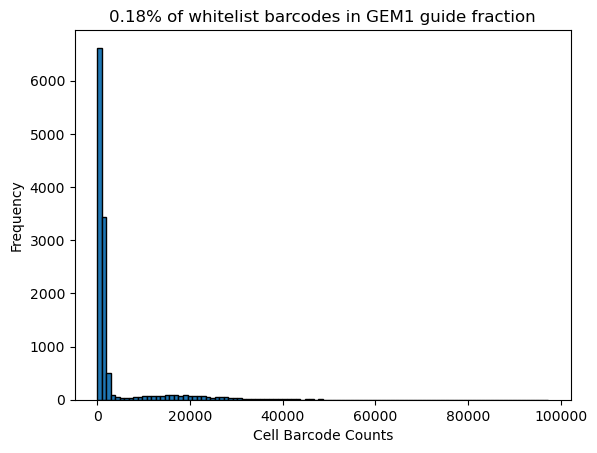

In [17]:
import matplotlib.pyplot as plt

data = cellbc_counts_SL424_R1_GEM1['count'].tolist()
plt.hist(data, bins=100, edgecolor='black')
plt.xlabel('Cell Barcode Counts')
plt.ylabel('Frequency')
plt.title('0.18% of whitelist barcodes in GEM1 guide fraction')
plt.show()

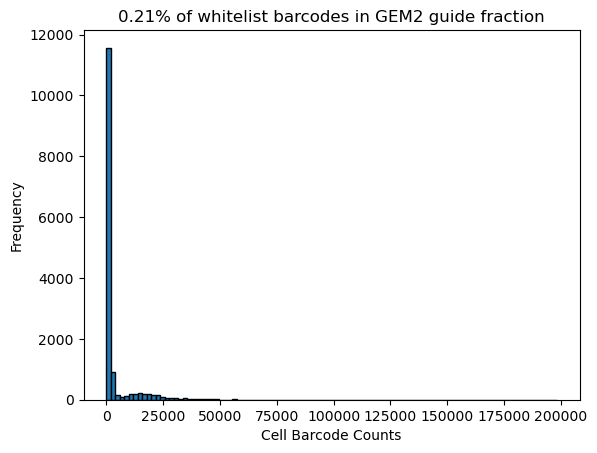

In [18]:
import matplotlib.pyplot as plt

data = cellbc_counts_SL425_R1_GEM2['count'].tolist()
plt.hist(data, bins=100, edgecolor='black')
plt.xlabel('Cell Barcode Counts')
plt.ylabel('Frequency')
plt.title('0.21% of whitelist barcodes in GEM2 guide fraction')
plt.show()

## percent of valid droplet barcodes in expression data present in guide data with at least one guide

In [26]:
## load in expression data cell barcode reads
SL422_R1_GEM1 = obtain_reads(path, sample_names[4], 0, 16)
SL423_R1_GEM2 = obtain_reads(path, sample_names[5], 0, 16)

In [27]:
## find unique cell barcodes in expression data that are valid
exp_data_cellbc_GEM1 = set(SL422_R1_GEM1).intersection(set(cellbc10x_white_list))
exp_data_cellbc_GEM2 = set(SL423_R1_GEM2).intersection(set(cellbc10x_white_list))

print(f'Valid droplet barcodes in GEM1 expression data: {len(exp_data_cellbc_GEM1)}')
print(f'Valid droplet barcodes in GEM2 expression data: {len(exp_data_cellbc_GEM2)}')

Valid droplet barcodes in GEM1 expression data: 1906126
Valid droplet barcodes in GEM2 expression data: 1967817


In [28]:
## match cell barcodes in expression data to cell barcodes in guide data
exp_cellbc_to_guide_cellbc = pd.read_csv('/home/ssobti/tools/cellranger-7.1.0/lib/python/cellranger/barcodes/translation/3M-february-2018.txt.gz', compression='gzip', header=None, names=['exp_bc', 'guide_bc'], sep = '\t')
guide_cellbc_to_exp_cellbc_dict = dict(zip(exp_cellbc_to_guide_cellbc['guide_bc'], exp_cellbc_to_guide_cellbc['exp_bc']))
exp_cellbc_to_guide_cellbc_dict = dict(zip(exp_cellbc_to_guide_cellbc['exp_bc'], exp_cellbc_to_guide_cellbc['guide_bc']))

In [29]:
guide_cellbc_converted_to_exp_cellbc_GEM1 = [guide_cellbc_to_exp_cellbc_dict[barcode] for barcode in SL424_GEM1_cellbc_unique_w_guide]
guide_cellbc_converted_to_exp_cellbc_GEM2 = [guide_cellbc_to_exp_cellbc_dict[barcode] for barcode in SL425_GEM2_cellbc_unique_w_guide]

In [30]:
## percent of valid droplet barcodes in expression data that are also in guide data with at least one guide
print(f'Number of valid droplet barcodes in GEM1 intersecting between expression and guide fraction: {len(set(exp_data_cellbc_GEM1).intersection(set(guide_cellbc_converted_to_exp_cellbc_GEM1)))}')
print(f'Number of valid droplet barcodes in GEM2 intersecting between expression and guide fraction: {len(set(exp_data_cellbc_GEM2).intersection(set(guide_cellbc_converted_to_exp_cellbc_GEM2)))}')

print(f'Percent of valid droplet barcodes in GEM1 in expression fraction present in guide fraction: {100*len(set(exp_data_cellbc_GEM1).intersection(set(guide_cellbc_converted_to_exp_cellbc_GEM1)))/len(exp_data_cellbc_GEM1)}')
print(f'Percent of valid droplet barcodes in GEM2 in expression fraction present in guide fraction: {100*len(set(exp_data_cellbc_GEM2).intersection(set(guide_cellbc_converted_to_exp_cellbc_GEM2)))/len(exp_data_cellbc_GEM2)}')

Number of valid droplet barcodes in GEM1 intersecting between expression and guide fraction: 12416
Number of valid droplet barcodes in GEM2 intersecting between expression and guide fraction: 14487
Percent of valid droplet barcodes in GEM1 in expression fraction present in guide fraction: 0.6513735188544724
Percent of valid droplet barcodes in GEM2 in expression fraction present in guide fraction: 0.7361965060775468


## percent of valid droplet barcodes containing ACTUAL cells in expression data present in guide data with at least one guide

In [8]:
## load in barcodes of valid droplets contianing cells

cell_bcs_w_actual_cells_GEM1 = pd.read_csv('/home/ssobti/projects/heterogeneity_brian/data/072623_MD231_CRISPRa_repeat_screen/cellranger/GEM1_CRISPRa_BC_untethered/outs/filtered_feature_bc_matrix/barcodes.tsv.gz', header=None)[0].tolist()
cell_bcs_w_actual_cells_GEM1 = [x.split('-')[0] for x in cell_bcs_w_actual_cells_GEM1]

cell_bcs_w_actual_cells_GEM2 = pd.read_csv('/home/ssobti/projects/heterogeneity_brian/data/072623_MD231_CRISPRa_repeat_screen/cellranger/GEM2_CRISPRa_BC_untethered/outs/filtered_feature_bc_matrix/barcodes.tsv.gz', header=None)[0].tolist()
cell_bcs_w_actual_cells_GEM2 = [x.split('-')[0] for x in cell_bcs_w_actual_cells_GEM2]

In [48]:
## percent of valid droplet barcodes in expression data that are also in guide data with at least one guide
print(f'Number of valid cell barcodes with at least one guide in GEM1 intersecting between expression and guide fraction: {len(set(cell_bcs_w_actual_cells_GEM1).intersection(set(guide_cellbc_converted_to_exp_cellbc_GEM1)))}')
print(f'Number of valid cell barcodes with at least one guide in GEM2 intersecting between expression and guide fraction: {len(set(cell_bcs_w_actual_cells_GEM2).intersection(set(guide_cellbc_converted_to_exp_cellbc_GEM2)))}')

print(f'Percent of valid cell barcodes with at least one guide in GEM1 in expression fraction present in guide fraction: {100*len(set(cell_bcs_w_actual_cells_GEM1).intersection(set(guide_cellbc_converted_to_exp_cellbc_GEM1)))/len(cell_bcs_w_actual_cells_GEM1)}')
print(f'Percent of valid cell barcodes with at least one guide in GEM2 in expression fraction present in guide fraction: {100*len(set(cell_bcs_w_actual_cells_GEM2).intersection(set(guide_cellbc_converted_to_exp_cellbc_GEM2)))/len(cell_bcs_w_actual_cells_GEM2)}')

Number of valid cell barcodes with at least one guide in GEM1 intersecting between expression and guide fraction: 1902
Number of valid cell barcodes with at least one guide in GEM2 intersecting between expression and guide fraction: 2355
Percent of valid cell barcodes with at least one guide in GEM1 in expression fraction present in guide fraction: 29.995268885033905
Percent of valid cell barcodes with at least one guide in GEM2 in expression fraction present in guide fraction: 31.751381960361332


## Guide fraction: number of guide fraction reads per valid droplet barcode containing ACTUAL cells with at least one guide. Note: most of these droplets are empty

In [38]:
cellbc_counts_SL424_R1_GEM1 = pd.DataFrame(columns = ['cellbc', 'count'])
for cellbc in cell_bcs_w_actual_cells_GEM1:
    cellbc_counts_SL424_R1_GEM1 = pd.concat([cellbc_counts_SL424_R1_GEM1, pd.DataFrame([[cellbc, SL424_R1_GEM1_cellbc_counts[cellbc]]], columns = ['cellbc', 'count'])], axis = 0).reset_index(drop = True)

cellbc_counts_SL425_R1_GEM2 = pd.DataFrame(columns = ['cellbc', 'count'])
for cellbc in cell_bcs_w_actual_cells_GEM2:
    cellbc_counts_SL425_R1_GEM2 = pd.concat([cellbc_counts_SL425_R1_GEM2, pd.DataFrame([[cellbc, SL425_R1_GEM2_cellbc_counts[cellbc]]], columns = ['cellbc', 'count'])], axis = 0).reset_index(drop = True)

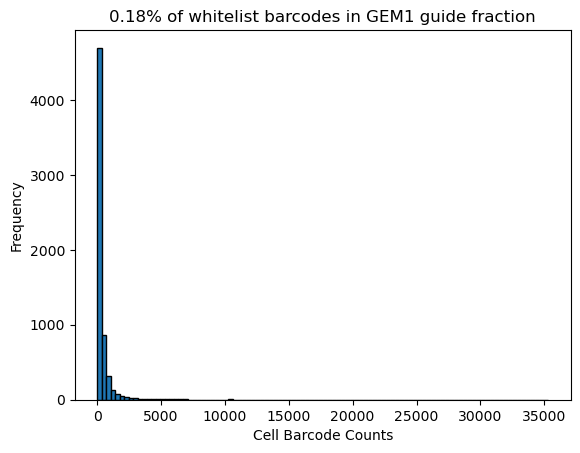

In [74]:
import matplotlib.pyplot as plt

data = cellbc_counts_SL424_R1_GEM1['count'].tolist()
plt.hist(data, bins=100, edgecolor='black')
plt.xlabel('Cell Barcode Counts')
plt.ylabel('Frequency')
plt.title('0.18% of whitelist barcodes in GEM1 guide fraction')
plt.show()

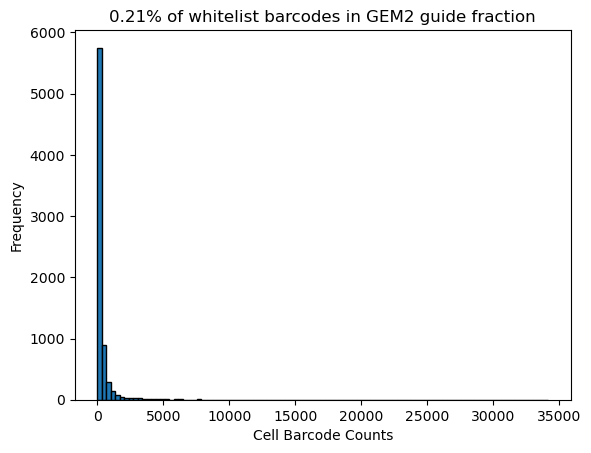

In [75]:
import matplotlib.pyplot as plt

data = cellbc_counts_SL425_R1_GEM2['count'].tolist()
plt.hist(data, bins=100, edgecolor='black')
plt.xlabel('Cell Barcode Counts')
plt.ylabel('Frequency')
plt.title('0.21% of whitelist barcodes in GEM2 guide fraction')
plt.show()

In [47]:
## usable read ratio obtained from cellranger count report
## expect discrepancies in mean usable read counts due to not accounting for fuzzy matching

print(f"Mean read counts per guide in GEM1 guide fraction (only valid cells with at least one guide used): {np.mean(cellbc_counts_SL424_R1_GEM1['count'])}")
print(f"Mean read counts per guide in GEM2 guide fraction (only valid cells with at least one guide used): {np.mean(cellbc_counts_SL425_R1_GEM2['count'])}")

print(f"Mean usable read counts per guide in GEM1 guide fraction (only valid cells with at least one guide used): {0.7*np.mean(cellbc_counts_SL424_R1_GEM1['count'])/1.2}")
print(f"Mean usable read counts per guide in GEM2 guide fraction (only valid cells with at least one guide used): {0.9*np.mean(cellbc_counts_SL425_R1_GEM2['count'])/1.5}")

Mean read counts per guide in GEM1 guide fraction (only valid cells with at least one guide used): 407.12395521211164
Mean read counts per guide in GEM2 guide fraction (only valid cells with at least one guide used): 357.4028582985034
Mean usable read counts per guide in GEM1 guide fraction (only valid cells with at least one guide used): 237.48897387373177
Mean usable read counts per guide in GEM2 guide fraction (only valid cells with at least one guide used): 214.44171497910204
